In [1]:
import numpy
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas
import mglearn
import os
import scipy

import sklearn
import sklearn.ensemble              # import seperatley otherwise sub module won't be imported
import sklearn.neural_network        # import seperatley otherwise sub module won't be imported
from sklearn.cluster import KMeans
import sklearn.feature_selection

import graphviz
import mpl_toolkits.mplot3d as plt3dd

import time

When selecting a metric, you should always have the end goal of the machine learning application in mind. In practice, we are usually interested not just in making accurate predictions, but in using these predictions as part of a larger decisionmaking process. Before picking a machine learning metric, you should think about the high-level goal of the application, often called the $business$ $metric$.

When choosing a model or adjusting parameters, you should pick the model or parameter values that have the most positive influence on the business metric. Often this is hard, as assessing the business impact of a particular model might require putting it in production in a real-life system.


In the early stages of development, and for adjusting parameters, it is often infeasible to put models into production just for testing purposes, because of the high business or personal risks that can be involved.

# Metrics for binary classification

Binary classification is arguably the most common and conceptually simple application of machine learning in practice. However, there are still a number of caveats in evaluating even this simple task.

Remember that for binary classification, we often speak of a positive class and a negative class, with the understanding that the positive class is the one we are looking for.

Often, accuracy is not a good measure of predictive performance, as the number of mistakes we make does not contain all the information we are interested in.

## Kinds of errors: Imbalanced datasets

In [2]:
digits = sklearn.datasets.load_digits();

y = digits.target == 9;
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(digits.data, y, random_state=0)

In [3]:
dummy_majority = sklearn.dummy.DummyClassifier(strategy="most_frequent").fit(X_train, y_train);

In [4]:
pred_most_frequent = dummy_majority.predict(X_test);

print("Unique predicted labels: {}".format(numpy.unique(pred_most_frequent)));
print("Test score: {:4.2f} %".format(100*dummy_majority.score(X_test, y_test)));

Unique predicted labels: [False]
Test score: 89.56 %


We obtained close to 90% accuracy without learning anything. This might seem striking, but think about it for a minute. Imagine someone telling you their model is 90% accurate. You might think they did a very good job. But depending on the problem, that might be possible by just predicting one class! Let’s compare this against using an actual classifier.

In [5]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=2).fit(X_train, y_train);
pred_tree = tree.predict(X_test); 
print("Test score: {:4.2f} %".format(100*tree.score(X_test, y_test)));

Test score: 91.78 %


According to accuracy, the DecisionTreeClassifier is only slightly better than the constant predictor. This could indicate either that something is wrong with how we used DecisionTreeClassifier, or that accuracy is in fact not a good measure here.

For comparison purposes, let’s evaluate two more classifiers, LogisticRegression and the default DummyClassifier, which makes random predictions but produces classes with the same proportions as in the training set:

In [6]:
dummy = sklearn.dummy.DummyClassifier().fit(X_train, y_train);
pred_dummy = dummy.predict(X_test);
print("dummy score: {:4.2f} %".format(100*dummy.score(X_test, y_test)));


logreg = sklearn.linear_model.LogisticRegression(C=0.1, max_iter=1000).fit(X_train, y_train);
pred_logreg = logreg.predict(X_test);
print("logreg score: {:4.2f} %".format(100*logreg.score(X_test, y_test)));

dummy score: 89.56 %
logreg score: 98.44 %


## Confusion matrices

One of the most comprehensive ways to represent the result of evaluating binary classification is using confusion matrices.

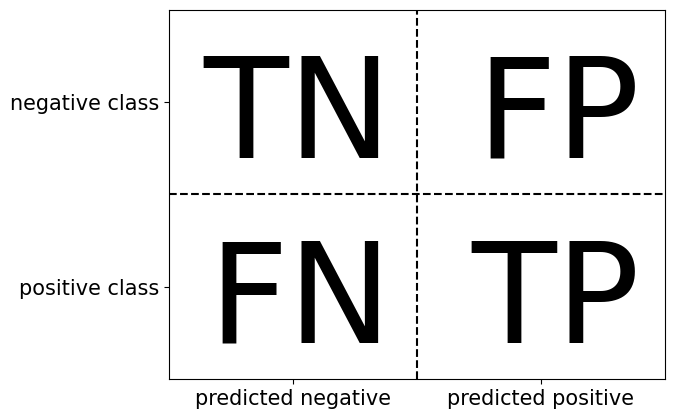

In [7]:
mglearn.plots.plot_binary_confusion_matrix();

Confusion matrix:
[[402   1]
 [  6  41]]


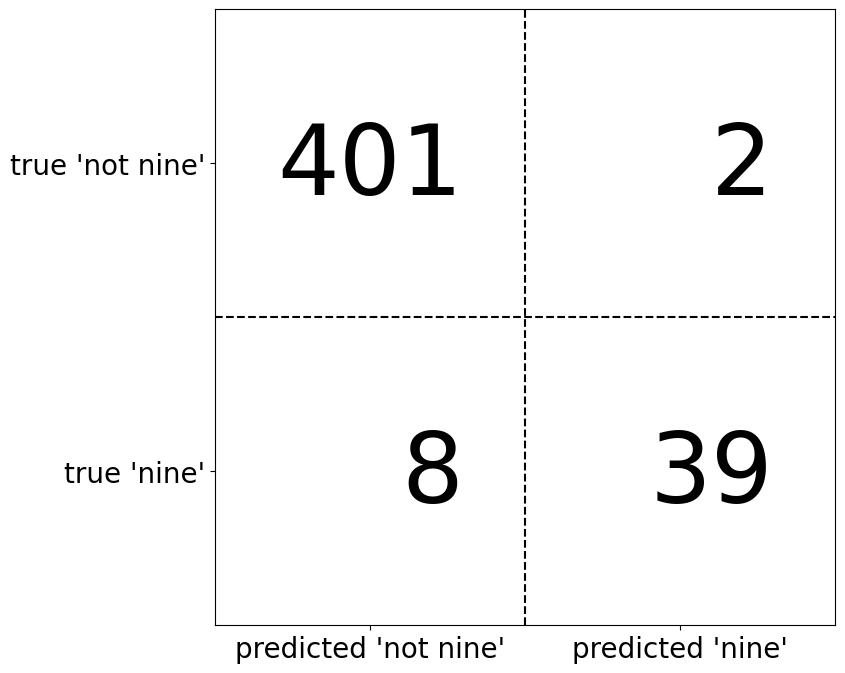

In [8]:
confusion = sklearn.metrics.confusion_matrix(y_test, pred_logreg);
print("Confusion matrix:\n{}".format(confusion));
mglearn.plots.plot_confusion_matrix_illustration()

In [9]:
print("Most frequent class:")
print(sklearn.metrics.confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(sklearn.metrics.confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(sklearn.metrics.confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(sklearn.metrics.confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[403   0]
 [ 47   0]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[402   1]
 [  6  41]]


### Relation to accuracy:

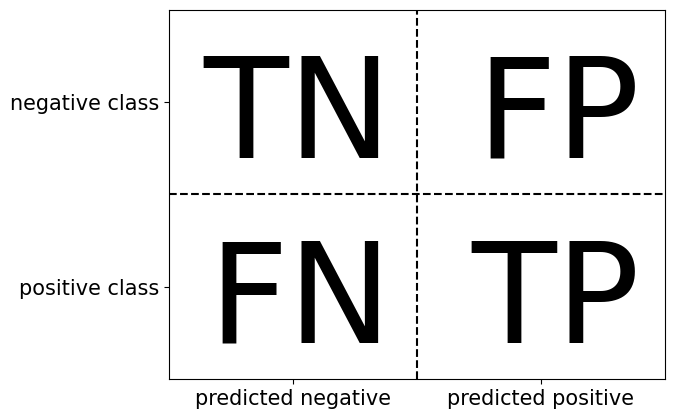

In [10]:
mglearn.plots.plot_binary_confusion_matrix();

$$Accuracy = \frac{TP + TN}{TP + TN + FN + FP}$$

Accuracy is the number of correct predictions (TP and TN) divided by the number of all samples (all entries of the confusion matrix summed up)

In [11]:
ConfMatr = sklearn.metrics.confusion_matrix(y_test, pred_logreg)
accuracy = (ConfMatr[0,0] + ConfMatr[1,1]) / (ConfMatr[0,0] + ConfMatr[1,1] + ConfMatr[0,1] + ConfMatr[1,0]);     
print(f"Confusion matrix accuracy: {numpy.round(accuracy*100,2)} %")

Confusion matrix accuracy: 98.44 %


### Precision, recall, and f-score

Precision measures how many of the samples predicted as positive are actually positive. Precision is used as a performance metric when the goal is to limit the number of false positive. It is important that the model does not produce many false positives—in other words, that it has a high precision. Precision is also known as positive predictive value (PPV).

$$Precision = \frac{TP}{TP + TN}$$

In [12]:
precision = (ConfMatr[1,1]) / (ConfMatr[0,0] + ConfMatr[1,1]);     
print(f"Confusion matrix precision: {numpy.round(precision*100,2)} %");

Confusion matrix precision: 9.26 %


Recall, on the other hand, measures how many of the positive samples are captured by the positive predictions:
$$Recall = \frac{TP}{TP + FN} $$

Recall is used as performance metric when we need to identify all positive samples; that is, when it is important to avoid false negatives. The cancer diagnosis example from earlier in this chapter is a good example for this: it is important to find all peo‐ ple that are sick, possibly including healthy patients in the prediction. Other names for recall are sensitivity, hit rate, or true positive rate (TPR).

In [13]:
recall = (ConfMatr[1,1]) / (ConfMatr[1,0] + ConfMatr[1,1]);     
print(f"Confusion matrix recall: {numpy.round(recall*100,2)} %");

Confusion matrix recall: 87.23 %


There is a trade-off between optimizing recall and optimizing precision. You can triv‐ ially obtain a perfect recall if you predict all samples to belong to the positive class— there will be no false negatives, and no true negatives either. However, predicting all samples as positive will result in many false positives, and therefore the precision will be very low. On the other hand, if you find a model that predicts only the single data point it is most sure about as positive and the rest as negative, then precision will be perfect (assuming this data point is in fact positive), but recall will be very bad.


Further information can be find in: https://en.wikipedia.org/wiki/Sensitivity_and_specificity

So, while precision and recall are very important measures, looking at only one of them will not provide you with the full picture. One way to summarize them is the f-score or f-measure, which is with the harmonic mean of precision and recall:

$$F = 2 \times \frac{precision \cdot recall}{precision + recall} $$

This particular variant is also known as the f1-score. As it takes precision and recall into account, it can be a better measure than accuracy on imbalanced binary classifi‐ cation datasets. Let’s run it on the predictions for the “nine vs. rest” dataset that we computed earlier. Here, we will assume that the “nine” class is the positive class (it is labeled as True while the rest is labeled as False), so the positive class is the minority class:

In [14]:
F = precision * recall * 2 / (precision + recall);
print(f"F1 score: {numpy.round(F*100,2)} %");

F1 score: 16.73 %


In [15]:
from sklearn.metrics import f1_score

In [16]:
print("f1 score most frequent: {:4.2f} %".format(f1_score(y_test,pred_most_frequent)*100))
print("f1 score dummy: {:4.2f} %".format(f1_score(y_test, pred_dummy)*100));
print("f1 score tree: {:4.2f} %".format(f1_score(y_test, pred_tree)*100));
print("f1 score logistic regression: {:4.2f} %".format(f1_score(y_test, pred_logreg)*100));

f1 score most frequent: 0.00 %
f1 score dummy: 0.00 %
f1 score tree: 55.42 %
f1 score logistic regression: 92.13 %


However, the f-score seems to capture our intuition of what makes a good model much better than accuracy did. A disadvantage of the f-score, however, is that it is harder to interpret and explain than accuracy.

If we want a more comprehensive summary of precision, recall, and f1-score, we can use the classification_report convenience function to compute all three at once, and print them in a nice format

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_test, pred_most_frequent,target_names=["not nine", "nine"]));

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\Users\wilco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wilco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wilco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [19]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]));

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\Users\wilco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wilco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wilco\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [20]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]));

              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



As you may notice when looking at the reports, the differences between the dummy models and a very good model are not as clear any more. Picking which class is declared the positive class has a big impact on the metrics. While the f-score for the dummy classification is 0.13 (vs. 0.89 for the logistic regression) on the “nine” class, for the “not nine” class it is 0.90 vs. 0.99, which both seem like reasonable results. Looking at all the numbers together paints a pretty accurate picture, though, and we can clearly see the superiority of the logistic regression model.

### Taking uncertainty into account

The following is an example of an imbalanced binary classification task, with 400 points in the negative class classified against 50 points in the positive class.

In [21]:
X, y = sklearn.datasets.make_blobs(n_samples=(400,50), centers=None, cluster_std=[7.0, 2], random_state=22);
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

Support Vector Machines (SVM):

- C: Regularization parameter. It controls/limits the importance of each point (or more precisely, their dual_coef_).
- Gamma ($\gamma$): Controls the width of the gaussian kernel

In [22]:
svc = sklearn.svm.SVC(gamma=0.5).fit(X_train, y_train);

In [23]:
report = sklearn.metrics.classification_report;
print(report(y_test, svc.predict(X_test)));

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       104
           1       0.20      0.33      0.25         9

    accuracy                           0.84       113
   macro avg       0.57      0.61      0.58       113
weighted avg       0.88      0.84      0.86       113



For class 1, we get a fairly small recall, and precision is mixed. Because class 0 is so much larger, the classifier focuses on getting class 0 right, and not the smaller class 1. Let’s assume in our application it is more important to have a high recall for class 1, as in the cancer screening example earlier. This means we are willing to risk more false positives (false class 1) in exchange for more true positives (which will increase the recall). The predictions generated by svc.predict really do not fulfill this requirement, but we can adjust the predictions to focus on a higher recall of class 1 by changing the decision threshold away from 0. By default, points with a deci sion_function value greater than 0 will be classified as class 1. We want more points to be classified as class 1, so we need to decrease the threshold.

In [24]:
y_pred_lower_threshold = svc.decision_function(X_test) > -0.8;
print(report(y_test, y_pred_lower_threshold));

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       104
           1       0.31      1.00      0.47         9

    accuracy                           0.82       113
   macro avg       0.66      0.90      0.68       113
weighted avg       0.95      0.82      0.86       113



Picking a threshold for models that implement the predict_proba method can be easier, as the output of predict_proba is on a fixed 0 to 1 scale, and models probabilities. By default, the threshold of 0.5 means that if the model is more than 50% “sure” that a point is of the positive class, it will be classified as such. Increasing the threshold means that the model needs to be more confident to make a positive decision (and less confident to make a negative decision). While working with probabilities may be more intuitive than working with arbitrary thresholds, not all models provide realistic models of uncertainty (a DecisionTree that is grown to its full depth is always 100% sure of its decisions, even though it might often be wrong). This relates to the concept of calibration: a calibrated model is a model that provides an accurate measure of its uncertainty.

More details for calibration can be found in : https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf

### Precision-recall curves and ROC curves

In [32]:
X, y = sklearn.datasets.make_blobs(n_samples=(4000, 500), centers=None, cluster_std=[7.0, 2], random_state=22);
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

svc = sklearn.svm.SVC(gamma=0.05).fit(X_train, y_train);

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, svc.decision_function(X_test));

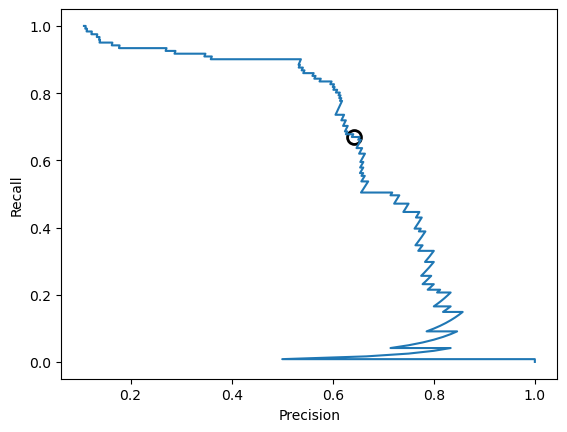

In [40]:
# find threshold closest to zero
close_zero = numpy.argmin(numpy.abs(thresholds));


plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,  label="threshold zero", 
                                                     fillstyle="none", c='k', mew=2);

plt.plot(precision, recall, '-b', label="precision recall curve");
plt.xlabel("Precision");
plt.ylabel("Recall");